In [1]:
import click

import evaluate
import numpy as np
from datasets import Dataset
import datasets as ds
from transformers import (
    DataCollatorForSeq2Seq,
    MT5ForConditionalGeneration,
    MT5Tokenizer,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator,
)


In [2]:
import pandas as pd
import functools as ft

In [3]:
model_name = "google/mt5-small"
flores_path = "../data-bin/flores-dev-no-orth"
ntrex_path = "../data-bin/ntrex-no-orth"
source_lang = "fin"
target_lang = "eng"
finetune_langs = "fin,eng,est".split(",")

In [4]:
# Load the MT5 tokenizer and model
tokenizer = MT5Tokenizer.from_pretrained(model_name)

flores = ds.load_from_disk(flores_path)
ntrex = ds.load_from_disk(ntrex_path)

# Define new dataset based on source and target lang as well as finetuning langs
source_data_finetune = ds.concatenate_datasets(
    [ntrex[lang] for lang in ntrex if ntrex[lang].num_rows == ntrex[target_lang].num_rows]
)  # .rename_column("text", "source")
target_data_finetune = ds.concatenate_datasets(
    [ntrex[target_lang] for lang in ntrex if ntrex[lang].num_rows == ntrex[target_lang].num_rows]
)  # .rename_column("text", "target")

data_for_finetune = ds.Dataset.from_dict(
    {
        "source": source_data_finetune["text"],
        "target": target_data_finetune["text"],
        "source_language": source_data_finetune["language"],
        "target_language": target_data_finetune["language"],
    }
)

# Define test data
# source_data_test = flores[source_lang]
# target_data_test = flores[target_lang]
source_data_test = ds.concatenate_datasets(
    [flores[lang] for lang in flores if flores[lang].num_rows == flores[target_lang].num_rows]
)
target_data_test = ds.concatenate_datasets(
    [flores[target_lang] for lang in flores if flores[lang].num_rows == flores[target_lang].num_rows]
)

data_for_test = ds.Dataset.from_dict(
    {
        "source": source_data_test["text"],
        "target": target_data_test["text"],
        "source_language": source_data_test["language"],
        "target_language": target_data_test["language"],
    }
)

In [5]:
ntrex_lengths = pd.Series({l: ntrex[l].num_rows for l in ntrex})

In [6]:
def preprocess_function(examples, max_length_tokens=128, add_prefix=True):

    if add_prefix:
        prefixes = [
            f"Translate from {srclang} to {tgtlang}: "

            for srclang, tgtlang in zip(
                examples["source_language"], examples["target_language"]
            )
        ]

        inputs = [f"{pf}{ex}" for pf, ex in zip(prefixes, examples["source"])]
    else:
        inputs = examples["source"]
    targets = examples["target"]
    model_inputs = tokenizer(
        inputs, text_target=targets, max_length=max_length_tokens, truncation=True
    )
    model_inputs["input_tokens"] = [
        tokenizer.convert_ids_to_tokens(ids) for ids in model_inputs["input_ids"]
    ]
    model_inputs["output_tokens"] = [
        tokenizer.convert_ids_to_tokens(ids) for ids in model_inputs["labels"]
    ]
    
    model_inputs['input_sentence'] = [" ".join(toks) for toks in model_inputs['input_tokens']]
    model_inputs['output_sentence'] = [" ".join(toks) for toks in model_inputs['output_tokens']]

    return model_inputs

## NTREX language names


In [7]:
import pandas as pd

In [8]:
%%bash
sed "s/\s/\t/" < ../data/ntrex/LANGUAGES.tsv > ../data/ntrex/LANGUAGES_tab.tsv

In [9]:
ntrex_languages = pd.read_csv("../data/ntrex/LANGUAGES_tab.tsv", sep="\t", header=None, names=['language_code', 'language'])

In [10]:
ntrex_lang_code_to_language = ntrex_languages.set_index("language_code").language.to_dict()

In [11]:
def get_long_language_ntrex(lang_code: str) -> str:
    out = ntrex_languages[ntrex_languages.language_code.str.startswith(lang_code)].language.head(1).tolist().pop(0)
    return out.strip()

### Language overlap between NTREX and FLORES

Let's assume we're training on NTREX-128 and evaluating on FLORES. We can compute the language coverage and token overlap statistics:

In [12]:
in_flores = set(ntrex) & set(flores)
not_in_flores = set(ntrex) - set(flores)

In [13]:
language_coverage = len(in_flores) / len(set(ntrex))

print(f"Language coverage: {round(100*language_coverage, 2)}%")
print("Languages not covered by FLORES:\n{}".format('\n'.join(f"- {lang}: {get_long_language_ntrex(lang)}" for lang in not_in_flores)))

Language coverage: 81.67%
Languages not covered by FLORES:
- mon: Mongolian
- tah: Tahitian
- swa: Swahili
- msa: Malay
- sqi: Albanian
- fil: Filipino
- mey: Hassaniyya
- lav: Latvian
- hmn: Hmong
- shi: Shilha
- nep: Nepali
- uzb: Uzbek
- pus: Pushto
- orm: Oromo
- div: Divehi
- aze: Azerbaijani (Latin)
- fuc: Pulaar
- nde: North Ndebele
- fas: Persian
- ton: Tonga (Tonga Islands)
- mlg: Malagasy
- ven: Venda


In [14]:
print("Languages covered by FLORES:\n{}".format('\n'.join(f"- {lang}: {get_long_language_ntrex(lang)}" for lang in in_flores)))

Languages covered by FLORES:
- smo: Samoan
- dzo: Dzongkha
- pol: Polish
- zul: Zulu
- isl: Icelandic
- lao: Lao
- deu: German
- yue: Cantonese
- nld: Dutch
- hun: Hungarian
- hau: Hausa
- kan: Kannada
- fij: Fijian
- jpn: Japanese
- ckb: Central Kurdish (Sorani)
- prs: Dari
- khm: Khmer
- kor: Korean
- fao: Faroese
- urd: Urdu
- mlt: Maltese
- bem: Bemba
- uig: Uighur
- ibo: Igbo
- bod: Tibetan
- afr: Afrikaans
- est: Estonian
- eus: Basque
- cym: Welsh
- hin: Hindi
- slv: Slovenian
- nso: Northern Sotho
- rus: Russian
- pan: Panjabi
- ell: Greek
- heb: Hebrew
- yor: Yoruba
- tam: Tamil
- cat: Catalan
- hye: Armenian
- guj: Gujarati
- nno: Norwegian Nynorsk
- amh: Amharic
- por: Portuguese
- tgk: Tajik (Cyrillic)
- zho: Chinese (Simplified)
- bos: Bosnian
- sin: Sinhala
- arb: Arabic
- kin: Kinyarwanda
- spa: Spanish
- tha: Thai
- fra: French
- dan: Danish
- glg: Galician
- ind: Indonesian
- eng: English (British)
- bul: Bulgarian
- snd: Sindhi (Arabic)
- mal: Malayalam
- slk: Slovak


### Token overlap

First let's tokenize using the mT5 tokenizer:

In [15]:
import functools as ft

In [16]:
preprocess_no_prefix = ft.partial(preprocess_function, add_prefix=False)

In [17]:
data_for_finetune = data_for_finetune.map(preprocess_no_prefix, batched=True)

Map:   0%|          | 0/227658 [00:00<?, ? examples/s]

In [18]:
data_for_test = data_for_test.map(preprocess_no_prefix, batched=True)

Map:   0%|          | 0/195412 [00:00<?, ? examples/s]

Now, we can compute overlap stats for subwords:

In [19]:
import itertools as it
from collections import Counter

def flatten(nested: list[list[str]], return_type=list) -> list[str]:
    return return_type(it.chain.from_iterable(nested))

def get_unique_tokens(examples):
    return flatten(examples, return_type=set)

def get_unique_token_counts(examples):
    return Counter(flatten(examples))

def bigrams(lst):
    return zip(lst, lst[1:])

def get_unique_bigram_counts(examples):
    bg = flatten(examples, return_type=lambda x: bigrams(list(x)))
    return Counter(bg)

Let's check how many redundant rows there are (should be 1997, the NTREX per-lang size):

In [20]:
# These rows are redundant since the source and target langs are the same
redundant_rows = data_for_finetune.filter(lambda d: d['source_language'] == d['target_language'])

Filter:   0%|          | 0/227658 [00:00<?, ? examples/s]

In [21]:
redundant_rows

Dataset({
    features: ['source', 'target', 'source_language', 'target_language', 'input_ids', 'attention_mask', 'labels', 'input_tokens', 'output_tokens', 'input_sentence', 'output_sentence'],
    num_rows: 1997
})

Yup that matches! So this means that even the English rows are in the source tokens. 

Now let's do the subword overlap:

In [22]:
subword_tokens_in_ntrex = get_unique_token_counts(data_for_finetune['input_tokens'])
subword_tokens_in_flores = get_unique_token_counts(data_for_test['input_tokens'])

In [23]:
df_subword_tokens_in_ntrex = pd.DataFrame.from_dict(subword_tokens_in_ntrex, orient='index', columns=['n_occ_ntrex'])
df_subword_tokens_in_ntrex.index.name = "subword"
df_subword_tokens_in_ntrex.reset_index(inplace=True)

In [24]:
df_subword_tokens_in_flores = pd.DataFrame.from_dict(subword_tokens_in_flores, orient='index', columns=['n_occ_flores'])
df_subword_tokens_in_flores.index.name = "subword"
df_subword_tokens_in_flores.reset_index(inplace=True)

In [25]:
subword_occurrence_combined = pd.merge(left=df_subword_tokens_in_flores, right=df_subword_tokens_in_ntrex, left_on='subword', right_on='subword')
subword_occurrence_combined = subword_occurrence_combined.sort_values("n_occ_ntrex", ascending=False).reset_index(drop=True)

In [26]:
subword_occurrence_combined.set_index("subword", inplace=True)
subword_occurrence_combined = subword_occurrence_combined.rename(columns={
    "n_occ_ntrex": "Occurrences (NTREX)",
    "n_occ_flores": "Occurrences (FLORES)"
})

In [27]:
BACKEND = "matplotlib"
pd.set_option("plotting.backend", BACKEND)

In [28]:
import matplotlib.pyplot as plt

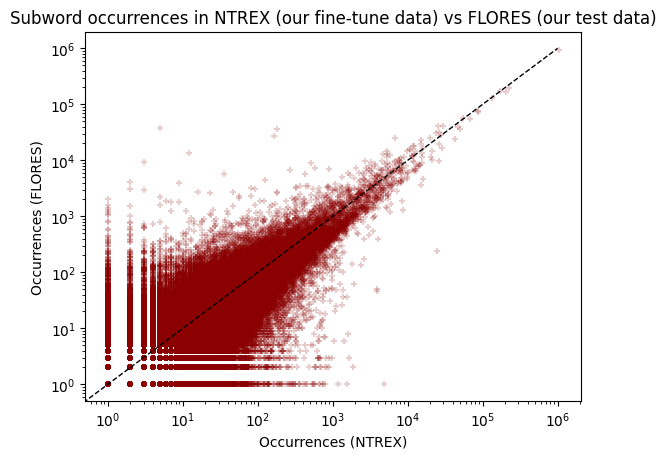

In [29]:
subword_occurrence_combined.plot(
    x='Occurrences (NTREX)', y='Occurrences (FLORES)', 
    logx=True, logy=True, kind='scatter', 
    title="Subword occurrences in NTREX (our fine-tune data) vs FLORES (our test data)",
    alpha=0.2, color='darkred', marker='+'
)
plt.plot([0, 10**6], [0, 10**6], linestyle='--', color='black', alpha=1, linewidth=1)

In [30]:
df = subword_occurrence_combined
df.assign(Difference=df['Occurrences (FLORES)'] - df['Occurrences (NTREX)']).sort_values("Difference", ascending=False)

,Occurrences (FLORES),Occurrences (NTREX),Difference
subword,,,
<0xB1>,37821,5,37816
<0xE1>,35644,181,35463
ɛ,27173,165,27008
ɔ,24674,6813,17861
n,40478,25570,14908
...,...,...,...
་,24092,42140,-18048
ʻ,241,24309,-24068
</s>,195412,227658,-32246


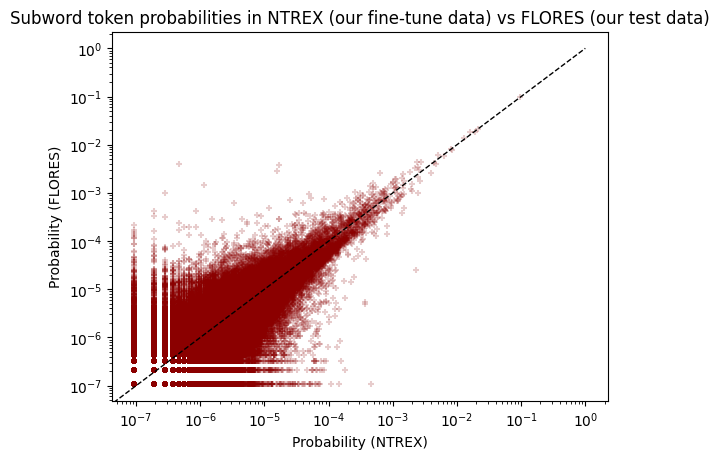

In [31]:
NORMALIZE=True

if NORMALIZE:
    df = subword_occurrence_combined / subword_occurrence_combined.sum(axis=0)
    df.rename(columns={"Occurrences (NTREX)": "Probability (NTREX)", 
                       "Occurrences (FLORES)": "Probability (FLORES)"}, inplace=True)
else:
    df = subword_occurrence_combined

df.plot(
    x='{} (NTREX)'.format("Probability" if NORMALIZE else "Occurrences"), 
    y='{} (FLORES)'.format("Probability" if NORMALIZE else "Occurrences"), 
    kind='scatter', 
    logx=True, logy=True, 
    title="Subword token {} in NTREX (our fine-tune data) vs FLORES (our test data)".format(
        "probabilities" if NORMALIZE else "occurrences"),
    alpha=0.2, color='darkred', marker='+'
)

x_top = 1 if NORMALIZE else df.max().max()
plt.plot([0, x_top], [0, x_top], linestyle='--', color='black', alpha=1, linewidth=1)

In [32]:
df.assign(Difference=df['Probability (FLORES)'] - df['Probability (NTREX)']).sort_values("Difference", ascending=False)

,Probability (FLORES),Probability (NTREX),Difference
subword,,,
<0xB1>,0.004027,4.699385e-07,0.004027
<0xE1>,0.003795,1.701178e-05,0.003778
ɛ,0.002893,1.550797e-05,0.002878
.,0.018769,1.605630e-02,0.002713
ɔ,0.002627,6.403383e-04,0.001987
...,...,...,...
:,0.000489,1.490175e-03,-0.001001
▁“,0.000388,1.412353e-03,-0.001024
་,0.002565,3.960642e-03,-0.001395


Let's do the same for subword bigrams:

In [33]:
subword_bigrams_in_ntrex = get_unique_bigram_counts(data_for_finetune['input_tokens'])
subword_bigrams_in_flores = get_unique_bigram_counts(data_for_test['input_tokens'])

In [34]:
df_subword_bigrams_in_ntrex = pd.DataFrame.from_dict(subword_bigrams_in_ntrex, orient='index', columns=['n_occ_ntrex'])
df_subword_bigrams_in_ntrex.index.name = "subword"
df_subword_bigrams_in_ntrex.reset_index(inplace=True)

In [35]:
df_subword_bigrams_in_flores = pd.DataFrame.from_dict(subword_bigrams_in_flores, orient='index', columns=['n_occ_flores'])
df_subword_bigrams_in_flores.index.name = "subword"
df_subword_bigrams_in_flores.reset_index(inplace=True)

In [36]:
subword_bigram_occurrence_combined = pd.merge(left=df_subword_bigrams_in_flores, right=df_subword_bigrams_in_ntrex, left_on='subword', right_on='subword')
subword_bigram_occurrence_combined = subword_bigram_occurrence_combined.sort_values("n_occ_ntrex", ascending=False).reset_index(drop=True)

In [37]:
subword_bigram_occurrence_combined.set_index("subword", inplace=True)
subword_bigram_occurrence_combined = subword_bigram_occurrence_combined.rename(columns={
    "n_occ_ntrex": "Occurrences (NTREX)",
    "n_occ_flores": "Occurrences (FLORES)"
})

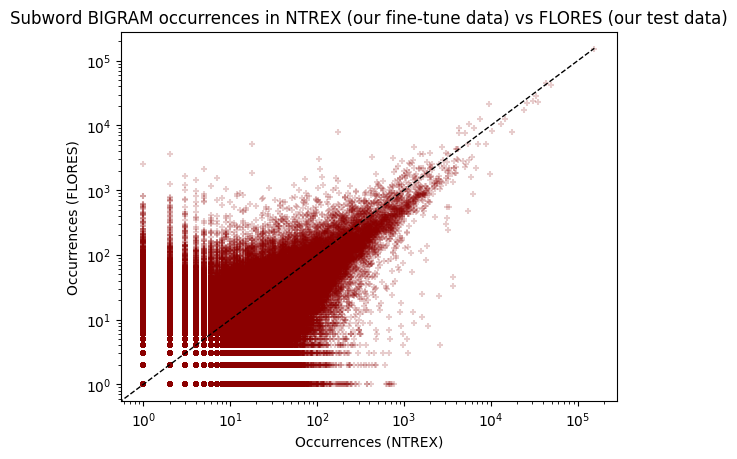

In [38]:
NORMALIZE=False

if NORMALIZE:
    df = subword_bigram_occurrence_combined / subword_bigram_occurrence_combined.sum(axis=0)
    df.rename(columns={"Occurrences (NTREX)": "Probability (NTREX)", 
                       "Occurrences (FLORES)": "Probability (FLORES)"}, inplace=True)
else:
    df = subword_bigram_occurrence_combined

df.plot(
    x='{} (NTREX)'.format("Probability" if NORMALIZE else "Occurrences"), 
    y='{} (FLORES)'.format("Probability" if NORMALIZE else "Occurrences"), 
    kind='scatter', 
    logx=True, logy=True, 
    title="Subword BIGRAM {} in NTREX (our fine-tune data) vs FLORES (our test data)".format(
        "probabilities" if NORMALIZE else "occurrences"),
    alpha=0.2, color='darkred', marker='+'
)

x_top = 1 if NORMALIZE else df.max().max()
plt.plot([0, x_top], [0, x_top], linestyle='--', color='black', alpha=1, linewidth=1)

In [39]:
df.assign(Difference=df['Occurrences (FLORES)'] - df['Occurrences (NTREX)']).sort_values("Difference", ascending=True)

,Occurrences (FLORES),Occurrences (NTREX),Difference
subword,,,
"(▁, i)",23346,34605,-11259
"(▁, u)",7864,17483,-9619
"(</s>, ▁"")",1800,9796,-7996
"(▁, o)",17254,23900,-6646
"(,, ▁)",42286,48925,-6639
...,...,...,...
"(▁, s)",12506,7578,4928
"(।, </s>)",10673,5601,5072
"(ɛ, ▁)",5116,18,5098


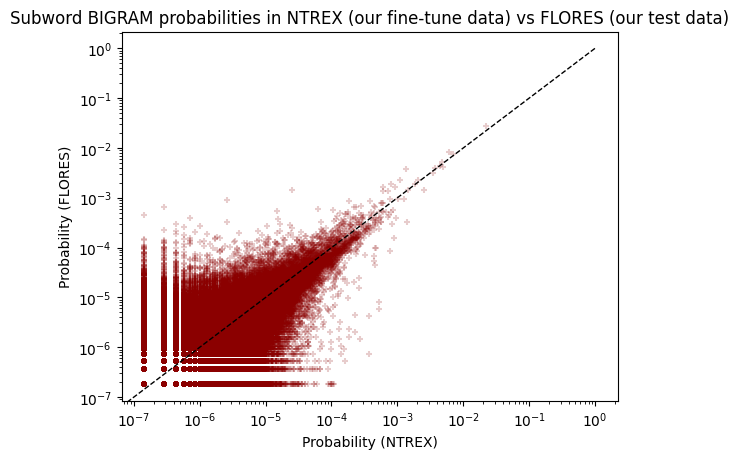

In [40]:
NORMALIZE=True

if NORMALIZE:
    df = subword_bigram_occurrence_combined / subword_bigram_occurrence_combined.sum(axis=0)
    df.rename(columns={"Occurrences (NTREX)": "Probability (NTREX)", 
                       "Occurrences (FLORES)": "Probability (FLORES)"}, inplace=True)
else:
    df = subword_bigram_occurrence_combined

df.plot(
    x='{} (NTREX)'.format("Probability" if NORMALIZE else "Occurrences"), 
    y='{} (FLORES)'.format("Probability" if NORMALIZE else "Occurrences"), 
    kind='scatter', 
    logx=True, logy=True, 
    title="Subword BIGRAM {} in NTREX (our fine-tune data) vs FLORES (our test data)".format(
        "probabilities" if NORMALIZE else "occurrences"),
    alpha=0.2, color='darkred', marker='+'
)

x_top = 1 if NORMALIZE else df.max().max()
plt.plot([0, x_top], [0, x_top], linestyle='--', color='black', alpha=1, linewidth=1)

Doesn't seem like there's any kind of discrepancies

In [41]:
df.assign(Difference=df['Probability (FLORES)'] - df['Probability (NTREX)']).sort_values("Difference", ascending=False)

,Probability (FLORES),Probability (NTREX),Difference
subword,,,
"(., </s>)",0.027615,0.022256,0.005359
"(▁, n)",0.003842,0.001366,0.002476
"(▁, a)",0.008137,0.006105,0.002031
"(▁, <0xE1>)",0.001442,0.000025,0.001417
"(▁, s)",0.002256,0.001084,0.001172
...,...,...,...
"(</s>, ▁“)",0.000085,0.000772,-0.000687
"(i, ▁te)",0.000158,0.000881,-0.000723
"(▁, i)",0.004212,0.004951,-0.000739


## We can do better than just uni/bigrams, right?

Let's try something like `scikit-learn`'s `CountVectorizer`:

In [42]:
# !pip install scikit-learn

In [43]:
import sklearn.feature_extraction.text as sk_feats

In [44]:
def split_on_space(text: str) -> list[str]:
    return text.split(" ")

In [106]:
NGRAM_FROM = 1
NGRAM_TO = 3

cv = sk_feats.CountVectorizer(
    tokenizer=split_on_space, analyzer="word", lowercase=False,
    ngram_range=(NGRAM_FROM, NGRAM_TO))

In [107]:
cv.fit(data_for_finetune['input_sentence'])

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(lowercase=False, ngram_range=(1, 3),
                tokenizer=<function split_on_space at 0x7f8ab3c15160>)

In [108]:
cv_feats = pd.Series(cv.get_feature_names_out())

In [109]:
TDM_finetune = cv.transform(data_for_finetune['input_sentence'])

In [110]:
TDM_test = cv.transform(data_for_test['input_sentence'])

In [111]:
TDM_finetune

<227658x9066076 sparse matrix of type '<class 'numpy.int64'>'
	with 29514104 stored elements in Compressed Sparse Row format>

In [112]:
TDM_test

<195412x9066076 sparse matrix of type '<class 'numpy.int64'>'
	with 14244587 stored elements in Compressed Sparse Row format>

## Language-specific subword distributions

In fact each language should have its own plot to make it clear where there isn't overlap between NTREX and FLORES. I guess I'm looking for some measure of subword sequence overlap.

In [113]:
data_finetune_df = data_for_finetune.to_pandas()

In [114]:
tdms = {}
for lang in data_finetune_df.source_language.unique():
#     print(lang)
    TDM_lang = cv.transform(data_finetune_df[data_finetune_df.source_language == lang].input_sentence)
    tdms[lang] = TDM_lang

In [115]:
def measure_tdm_overlap(tdm1, tdm2, return_diff=False, return_tuple=False, return_normalized=False):
    assert tdm1.shape == tdm2.shape 
    nrow, ncol = tdm1.shape
    total_size = nrow*ncol
    diff = tdm1 - tdm2
    nonzero_size = diff.count_nonzero()
    if return_tuple:
        return nonzero_size, total_size
    elif return_normalized:
        return nonzero_size/total_size
    else:
        return nonzero_size

In [116]:
import itertools as it

In [117]:
divergence_matrix = pd.DataFrame.from_records(it.product([lang for lang in tdms], [lang for lang in tdms]), columns=['lang1', 'lang2'])

In [118]:
divergence_matrix['div_tuple'] = divergence_matrix.apply(lambda row: measure_tdm_overlap(tdms[row.lang1], tdms[row.lang2], return_tuple=True), axis=1)

In [119]:
divergence_matrix['num_disagreements'] = divergence_matrix['div_tuple'].apply(lambda t: t[0])

In [120]:
divergence_matrix.drop(columns="div_tuple", inplace=True)

In [121]:
most_least_similar = divergence_matrix[divergence_matrix.lang1 != divergence_matrix.lang2].sort_values('num_disagreements')

In [122]:
most_least_similar['lang1'] = most_least_similar['lang1'].apply(lambda l: get_long_language_ntrex(l))
most_least_similar['lang2'] = most_least_similar['lang2'].apply(lambda l: get_long_language_ntrex(l))

In [123]:
most_least_similar.set_index(['lang1', 'lang2'], inplace=True)

In [124]:
most_least_similar.reset_index(inplace=True)

In [125]:
def compare_disagreements(lang1, lang2):
    mask1 = most_least_similar.lang1 == lang1
    mask2 = most_least_similar.lang2 == lang2
    
    threshold = most_least_similar[mask1&mask2].num_disagreements.tolist().pop()
    threshold_mask = most_least_similar.num_disagreements <= threshold
    
    return most_least_similar[mask1&threshold_mask]


<Axes: ylabel='lang1'>

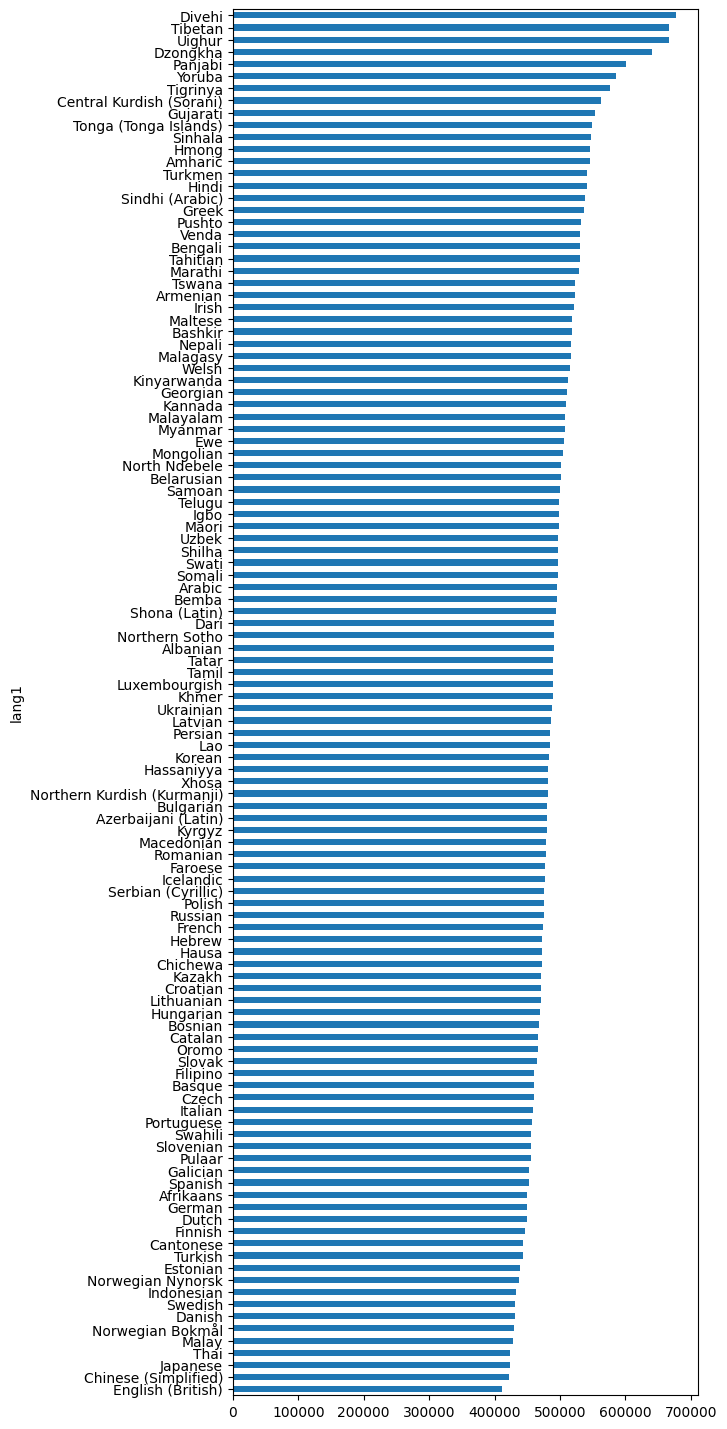

In [126]:
most_least_similar.groupby('lang1')\
    .num_disagreements.mean().round()\
    .sort_values(ascending=True)\
    .plot.barh(figsize=(6, 18))

In [127]:
import seaborn as sns

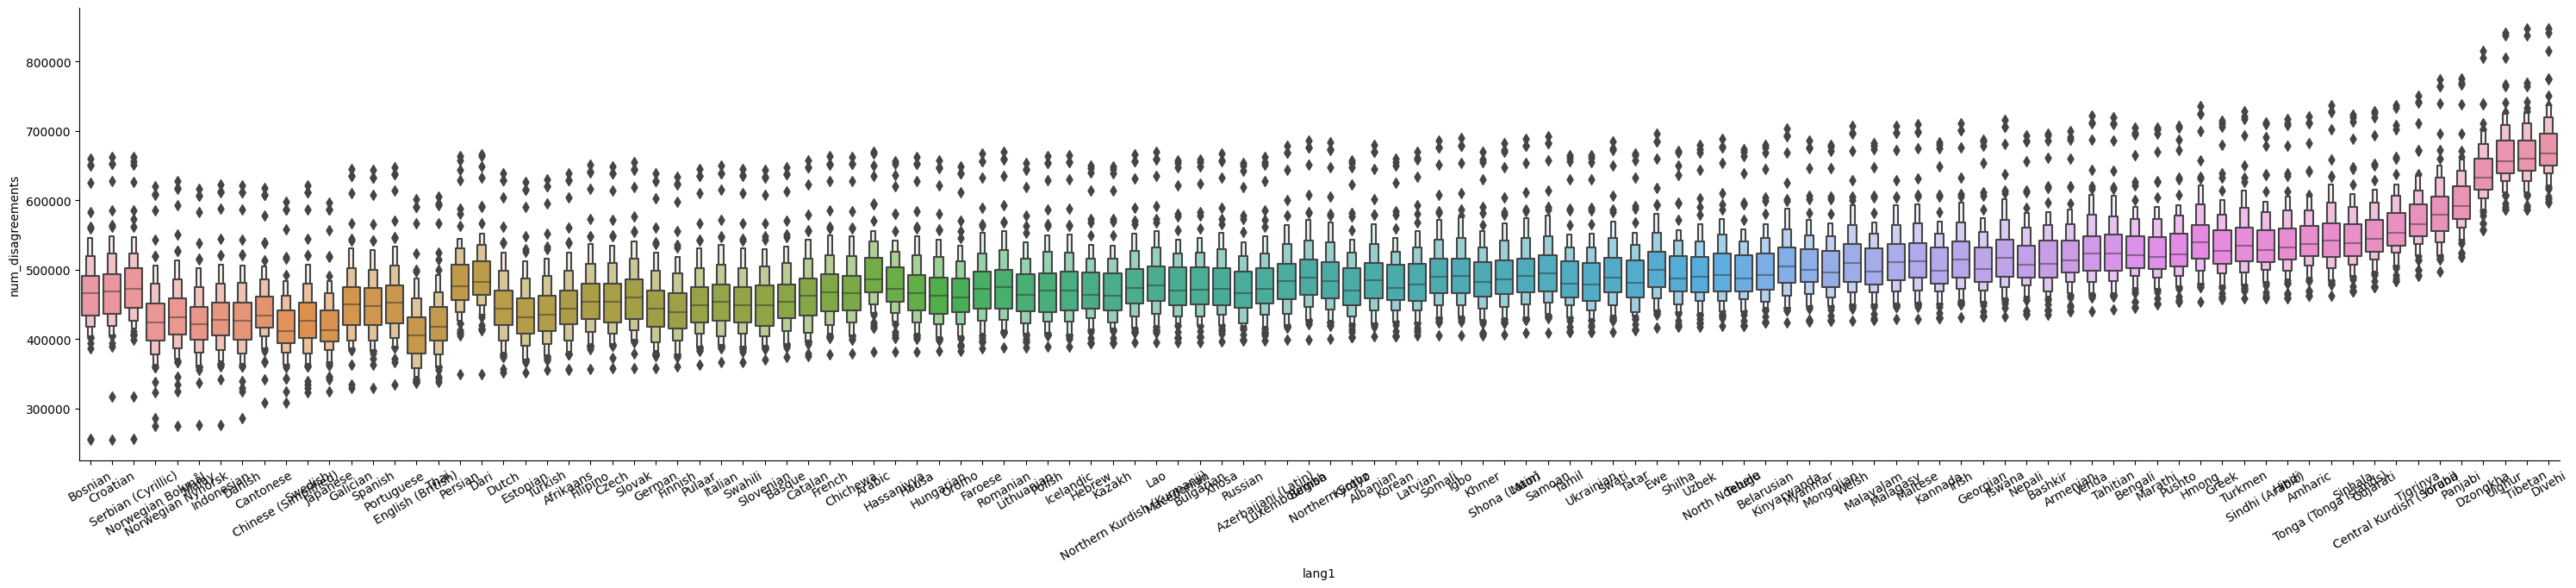

In [136]:
g = sns.catplot(
    data=most_least_similar, 
    y='num_disagreements',x='lang1',
    kind='boxen', 
    height=6, aspect=5,
)
g.set_xticklabels(rotation=30)